# Merit order evaluation
* Create an merit order plot from input data
* Merit order plot is a snapshot situation for one given RES infeed

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

from pommesevaluation.merit_order import (
    reshape_merit_order_data, plot_merit_order
)

## Read in and combine data
* Define settings
* Read in
  * costs: fuel, operation, emissions
  * capacities: for conventional and renewable transformers and other renewables
  * time series: renewable infeed and conventional transformers availability
* Combine into transformers resp. renewables data sets

In [2]:
input_folder = './model_inputs/'
simulation_year = 2017
fuel_cost_pathway = 'NZE'
emissions_cost_pathway = 'long-term'
time = f'{simulation_year}-08-05 13:00:00'

In [3]:
# transformers (i.e. generators)
transformers = pd.read_csv(input_folder+f'transformers_{simulation_year}.csv')
transformers = transformers.loc[
    transformers['country'] == 'DE', 
    ['label', 'fuel', 'capacity', 'efficiency_el']
]

# availabilities
availability_ts = pd.read_csv(input_folder+f'transformers_availability_ts_{simulation_year}.csv', index_col=0)
availability_factor = availability_ts.at[time, "values"]
transformers['capacity'] *= availability_factor 

# fuel costs
costs_fuel = pd.read_csv(input_folder+f'costs_fuel_{fuel_cost_pathway}_nominal_{simulation_year}.csv')
costs_fuel['fuel'] = [_[2] for _ in costs_fuel['label'].str.split('_')]
costs_fuel = costs_fuel.loc[costs_fuel['label'].str.contains('DE'), ['fuel', f'{simulation_year}']]
costs_fuel.rename(columns={f'{simulation_year}': 'costs_fuel'}, inplace=True)

# operation costs
costs_opex = pd.read_csv(input_folder+f'costs_operation_nominal_{simulation_year}.csv')
costs_opex['fuel'] = [_[2] for _ in costs_opex['label'].str.split('_')]
costs_opex = costs_opex.loc[costs_opex['label'].str.contains('DE'), ['fuel', f'{simulation_year}']]
costs_opex.rename(columns={f'{simulation_year}': 'costs_opex'}, inplace=True)

# emission costs
costs_emissions = pd.read_csv(input_folder+f'costs_emissions_{emissions_cost_pathway}_nominal_{simulation_year}.csv', index_col=0)
carbon_price = costs_emissions.at['DE_source_biomass', f'{simulation_year}']
transformers['carbon_price'] = carbon_price

# emission factors
sources_commodity = pd.read_csv(input_folder+f'sources_commodity_{simulation_year}.csv')
sources_commodity['fuel'] = [_[2] for _ in sources_commodity['label'].str.split('_')]
sources_commodity = sources_commodity.loc[sources_commodity['label'].str.contains('DE'), ['fuel', 'emission_factors']]

In [4]:
# Merge costs data and transformers
transformers = transformers.merge(costs_fuel, on='fuel', how='left')
transformers = transformers.merge(costs_opex, on='fuel', how='left')
transformers = transformers.merge(sources_commodity, on='fuel', how='left')
transformers['costs_carbon'] = transformers['emission_factors'] * transformers['carbon_price']

In [5]:
# fluctuating renewables capacity factors from time series
sources_res_ts = pd.read_csv(input_folder+f'sources_renewables_ts_{simulation_year}.csv', index_col=0)
sources_res_ts = sources_res_ts[sources_res_ts.columns[sources_res_ts.columns.str.contains('DE')]]
sources_res_ts = sources_res_ts.loc[time]
sources_res_ts = sources_res_ts.to_frame()
sources_res_ts.columns = ['capacity_factor']

In [6]:
# res capacities for non-fluctuating renewables
sources_res = pd.read_csv(input_folder+f'sources_renewables_{simulation_year}.csv', usecols=['label', 'capacity', 'country'])
sources_res['fuel'] = [_[2] for _ in sources_res['label'].str.split('_')]
sources_res = sources_res.merge(sources_res_ts, left_on='label', right_index=True, how='left')
sources_res['capacity'] *= sources_res['capacity_factor']
sources_res = sources_res.loc[sources_res['country'] == 'DE', ['fuel', 'capacity']]
sources_res.replace({'ROR': 'Wasser', 'Klaergas': 'Klärgas'}, inplace=True)
sources_res['costs_fuel'] = 0
sources_res['efficiency_el'] = 1
sources_res['label'] = sources_res['fuel']

In [7]:
# fluctuating renewables (renewable transformers)
transformers_res = pd.read_csv(input_folder+f'transformers_renewables_{simulation_year}.csv')

# renewables operation costs
costs_res = pd.read_csv(input_folder+f'costs_operation_renewables_{simulation_year}.csv')
transformers_res = transformers_res.merge(costs_res, on='label', how='left')

transformers_res = transformers_res.merge(sources_res_ts, left_on='from', right_index=True, how='left')
transformers_res['capacity'] *= transformers_res['capacity_factor']

transformers_res['fuel'] = [_[1] for _ in transformers_res['label'].str.split('_')]

# market values renewables
costs_market_values = pd.read_csv(input_folder+f'costs_market_values_{simulation_year}.csv', index_col=0)
costs_market_values = costs_market_values.loc[time].to_frame()
costs_market_values.columns = ['market_values']
transformers_res = transformers_res.merge(costs_market_values, right_index=True, left_on='from', how='left')

# derive costs for renewable transformers
transformers_res['costs_fuel'] = transformers_res['costs']+transformers_res['market_values']
exog_trafos = ['DE_solarPV_cluster_exogenous', 'DE_windoffshore_cluster_exogenous', 'DE_windonshore_cluster_exogenous']
transformers_res.loc[transformers_res['label'].isin(exog_trafos), 'costs_fuel'] = 0

transformers_res = transformers_res[['label', 'fuel', 'efficiency_el', 'capacity', 'costs_fuel']]

## Combine different data sets
* Merge all data sets
* Calculate marginal costs
* Sort values by marginal costs and calculate cumulated capacities

In [8]:
# merge
blocks = pd.concat([transformers, sources_res, transformers_res]).fillna(0)

# derive marginal costs
blocks['costs_marginal'] = (
    blocks["costs_opex"] +
    (blocks["costs_fuel"] + blocks["costs_carbon"]) / (blocks['efficiency_el'])
)

# derive cumulated capacity
blocks = blocks.sort_values(by='costs_marginal', ascending=True)
blocks["capacity_cumulated"] = blocks["capacity"].cumsum()

# assign symbolic euro(s) for illustration purposes
blocks.loc[blocks['costs_marginal'] == 0, 'costs_marginal'] = 2

In [9]:
fuel_dict = {
    'solarPV': 'Solare Strahlungsenergie',
    'windonshore': 'Windenergie an Land',
    'windoffshore': 'Windenergie auf See',
    'uranium': 'Kernenergie',
    'lignite': 'Braunkohle',
    'otherfossil': 'Andere fossile',
    'hardcoal': 'Steinkohle',
    'waste': 'Abfall',
    'mixedfuels': 'Mehrere fossile',
    'biomass': 'Biomasse',
    'biomassEEG': 'Biomasse',
    'landfillgas': 'Deponiegas',
    'geothermal': 'Geothermie',
    'minegas': 'Grubengas',
    'larga': 'Klärgas',
    'natgas': 'Erdgas',
    'oil': 'Heizöl'
}
blocks['fuel'].replace(fuel_dict, inplace=True)

In [10]:
# Define a color combination
colors = {
    'Solare Strahlungsenergie': '#fcb001',
    'Windenergie auf See': '#0504aa',
    'Windenergie an Land': '#82cafc',
    'Biomasse': '#15b01a',
    'Deponiegas': '#06c2ac',
    'Geothermie': '#ff474c',
    'Wasser': '#c79fef', 
    'Grubengas': '#650021', 
    'Klärgas': '#ad8150', 
    'Kernenergie': '#e50000',
    'Braunkohle': '#7f2b0a',
    'Andere fossile': '#d8dcd6',
    'Steinkohle': '#000000', 
    'Abfall': '#c04e01',
    'Mehrere fossile': '#a57e52',
    'Erdgas': '#929591', 
    'Heizöl': '#aaa662'
}

## Create actual merit order plot
* Reshape data set
* plot using steps

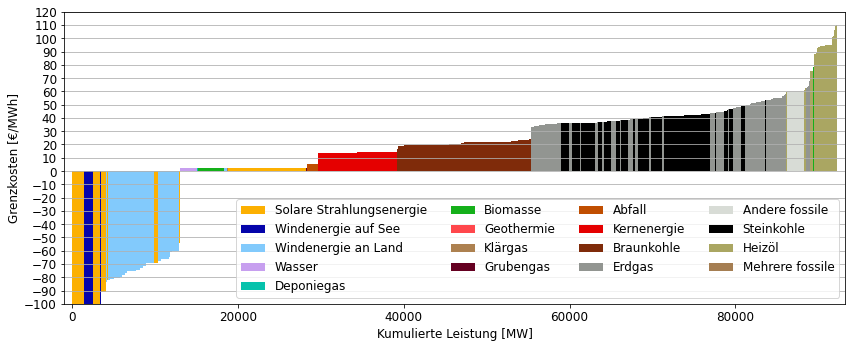

In [13]:
# Reshape data set
merit_order = reshape_merit_order_data(blocks)

plt.rcParams.update({'font.size': 12})

# Create actual plot
plot_merit_order(merit_order, colors, ylim=(-100, 120), set_ylim=True)

In [14]:
merit_order

,fuel,costs_marginal,capacity_cumulated
0,Solare Strahlungsenergie,-523.583923,0.768393
1,Solare Strahlungsenergie,-497.343933,2.849832
2,Solare Strahlungsenergie,-470.093933,6.598341
3,Solare Strahlungsenergie,-443.343933,20.841949
4,Solare Strahlungsenergie,-422.473938,38.497482
...,...,...,...
707,Heizöl,109.102928,92128.765625
708,Heizöl,110.008598,92197.039062
709,Heizöl,110.008598,92227.023438
710,Heizöl,111.649399,92247.578125
